In [13]:
import re
import sys
import time
import datetime as dt
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report, accuracy_score, f1_score


In [14]:
df = pd.read_csv('medical_appointment_dataset.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [15]:
# null value check
df.isnull().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

In [16]:
df['Age'].unique()


array([ 62,  56,   8,  76,  23,  39,  21,  19,  30,  29,  22,  28,  54,
        15,  50,  40,  46,   4,  13,  65,  45,  51,  32,  12,  61,  38,
        79,  18,  63,  64,  85,  59,  55,  71,  49,  78,  31,  58,  27,
         6,   2,  11,   7,   0,   3,   1,  69,  68,  60,  67,  36,  10,
        35,  20,  26,  34,  33,  16,  42,   5,  47,  17,  41,  44,  37,
        24,  66,  77,  81,  70,  53,  75,  73,  52,  74,  43,  89,  57,
        14,   9,  48,  83,  72,  25,  80,  87,  88,  84,  82,  90,  94,
        86,  91,  98,  92,  96,  93,  95,  97, 102, 115, 100,  99,  -1],
      dtype=int64)

In [17]:

df = df[(df['Age'] > 0) & (df['Age'] < 95)]

In [18]:

df['AppointmentDay'] = df['AppointmentDay'].apply(lambda x : x.replace('T00:00:00Z', ''))
df['AppointmentDay'] = pd.to_datetime(df['ScheduledDay'])

In [19]:
# extract days & months from the appointments
df['AppointmentDays'] = df['AppointmentDay'].apply(lambda x : dt.datetime.strftime(x, '%A'))
df['AppointmentMonths'] = df['AppointmentDay'].apply(lambda x : dt.datetime.strftime(x, '%B'))

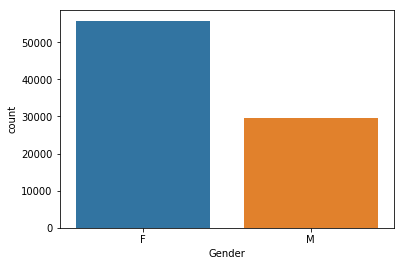

In [20]:
# who visits the doctor more often?
visits = df[df['No-show'] == 'No']
sns.countplot(x='Gender', data=visits)

In [21]:
# what is the proportion of male & female?
df['Gender'].value_counts(normalize = True)

F    0.655303
M    0.344697
Name: Gender, dtype: float64

In [22]:
# what is the proportion of no-shows
df['No-show'].value_counts(normalize = True)

No     0.797347
Yes    0.202653
Name: No-show, dtype: float64

In [23]:
# no. of patients who miss their appointments
len(df[df['No-show'] == 'Yes'].index)

21667

In [24]:
#percentage of no-show
len(df[df['No-show'] == 'Yes'].index) / len(df.index)

0.2026525248557292

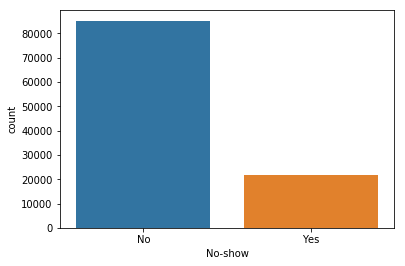

In [25]:
# visualise prcentage of no-shows
sns.countplot(x='No-show', data=df)


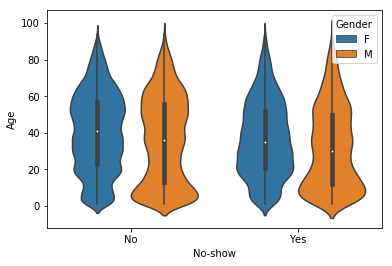

In [26]:
# male vs female age and its effect on showing?
sns.violinplot(df['No-show'], df['Age'], hue=df['Gender'])

In [27]:
# what is the patient age distribution for no-shows versus shows?
df.groupby('No-show')['Age'].mean()

No-show
No     39.036305
Yes    35.290211
Name: Age, dtype: float64

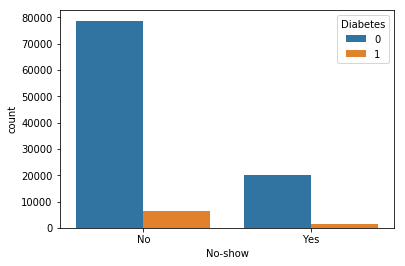

In [28]:
# what is the relationship between no-show and diabetes?
sns.countplot(x='No-show', hue='Diabetes', data=df)

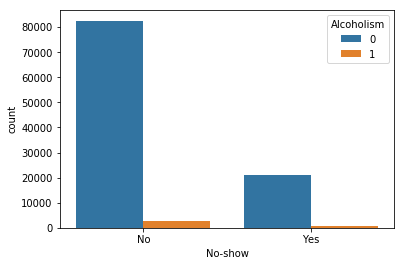

In [29]:
#relation between no-show and alcohlism
sns.countplot(x='No-show', hue='Alcoholism', data=df)

In [30]:
# which neighbourhoods have the highest number of shows?
shows = df[df['No-show'] == 'No']
shows.groupby('Neighbourhood')['No-show'].count().sort_values(ascending=False).head(20)

Neighbourhood
JARDIM CAMBURI       6149
MARIA ORTIZ          4367
RESISTÊNCIA          3360
JARDIM DA PENHA      3220
CENTRO               2586
SANTA MARTHA         2547
ITARARÉ              2514
TABUAZEIRO           2465
SANTO ANTÔNIO        2195
BONFIM               2161
JESUS DE NAZARETH    2043
SANTO ANDRÉ          1971
JABOUR               1963
CARATOÍRA            1902
SÃO PEDRO            1848
NOVA PALESTINA       1763
DA PENHA             1732
ILHA DO PRÍNCIPE     1697
ANDORINHAS           1685
ROMÃO                1660
Name: No-show, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

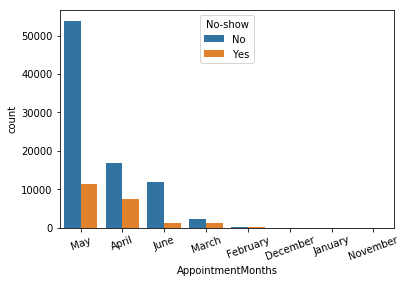

In [31]:
# in which month most patients miss their appointments
sns.countplot(x='AppointmentMonths', hue='No-show', data=df, order = df['AppointmentMonths'].value_counts().index)
plt.xticks(rotation=20)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

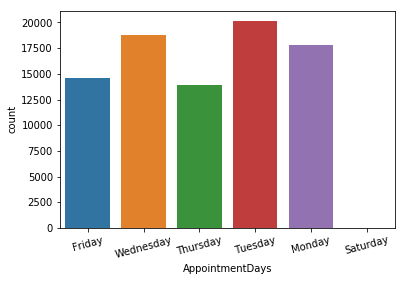

In [32]:
# in which day the patients visit their doctors most frequently?
sns.countplot(x='AppointmentDays', data=visits)
plt.xticks(rotation=15)

In [33]:
# is there specific weekday when most patients miss their appointments?
miss = df[df['No-show'] == 'Yes']
miss.groupby('AppointmentDays')['No-show'].count().sort_values(ascending=False)

AppointmentDays
Tuesday      5116
Wednesday    4755
Monday       4413
Friday       3794
Thursday     3588
Saturday        1
Name: No-show, dtype: int64

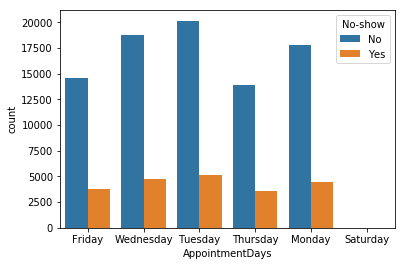

In [34]:
# what is the weekly no-show count
sns.countplot(x='AppointmentDays', hue='No-show', data=df)

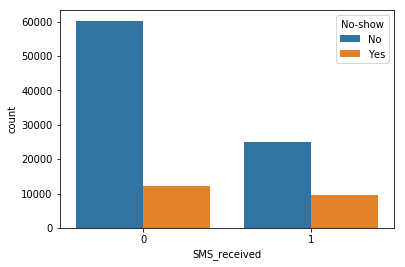

In [35]:
# how likely patients comes to their scheduled appointment if they have received a sms
sns.countplot(x='SMS_received', hue='No-show', data=df)

In [36]:
# converting categorical data to numerical data
df['Gender'] = pd.get_dummies(df['Gender'])

le = preprocessing.LabelEncoder()
df['Age'] = le.fit_transform(df['Age'])

le = preprocessing.LabelEncoder()
df['ScheduledDay'] = le.fit_transform(df['ScheduledDay'])

le = preprocessing.LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])

le = preprocessing.LabelEncoder()
df['AppointmentDay'] = le.fit_transform(df['AppointmentDay'])

F:\Ancondainstall\lib\site-packages\numpy\core\fromnumeric.py:1531: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return asanyarray(a).ravel(order=order)


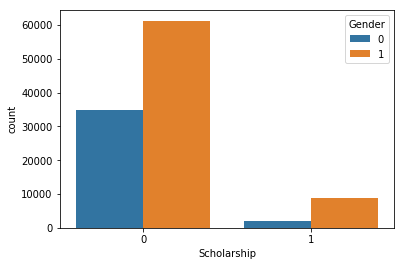

In [37]:
# what is the proportion of patients who has received familia scholarship?
sns.countplot(x='Scholarship', hue='Gender', data=df)

In [44]:
# split data
features = ['ScheduledDay', 'AppointmentDay', 'PatientId', 'AppointmentID', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
X = df[features]
y = df['No-show']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [45]:
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
knn_conf_mat = confusion_matrix(y_test, knn_y_pred)

Text(0.5,1,'Confusion Matrix')

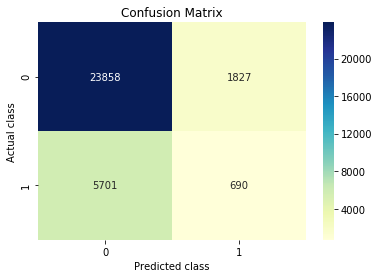

In [46]:
sns.heatmap(knn_conf_mat, cmap='YlGnBu', annot=True, fmt='d')
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.title('Confusion Matrix')

In [47]:
'Accuracy: ' + str(metrics.accuracy_score(y_test, knn_y_pred))

'Accuracy: 0.7653073949370246'

In [48]:
rf = RandomForestClassifier(n_estimators=260, max_depth=100, min_samples_split=50, min_samples_leaf=100, n_jobs=-1)
rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)
rn_conf_mat = confusion_matrix(y_test, rf_y_pred)

In [49]:
'Accuracy: ' + str(accuracy_score(y_test, rf_y_pred))


'Accuracy: 0.8008168100760693'

Text(0.5,1,'Confusion Matrix')

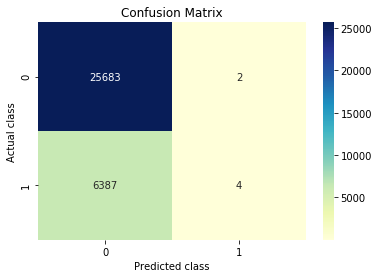

In [50]:
sns.heatmap(rn_conf_mat, cmap='YlGnBu', annot=True, fmt='d')
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.title('Confusion Matrix')